In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option("display.max_columns", 85)
sns.set_theme(context="paper", font_scale=1.5, style="ticks", rc={"axes.grid": True})

# Feature Importance of LR by PRAUC

#### Basic theory

The importance of a given feature to a model can be assessed by shuffling its values--destroying any information contained within--and measuring how much this act has impacted the model's performance. The loss of performance will measure how important a given feature is to the model.

Scikit-learn's `permutation_importance` class shuffles a feature and measures the impact of such shuffling on the scoring of the model. **This measures the importance of the feature to the model, not the importance of the feature in itself.**


#### Notebook summary

This notebook produces feature importance scores for the following models, SCORED ON PRAUC:
- Logistic Regression with no regularization in pipeline with Scaling and 95% EV PCA 
- Logistic Regression with no regularization in pipeline with Scaling and 100% EV PCA 
- Logistic Regression with no regularization in pipeline with Scaling but no PCA 
- Logistic Regression with no regularization applied to data that has been processed with Scaling and 100% EV PCA (outside of pipeline)

The data used in these experiments:
- Two foundational features: occ_total_sum and oldest_phylostratum
- 80 confounder variables including trinucleotidic frequencies. 
- Dropped from ACC to UVM
- Dropped TTT_freq
- Dropped oldest_phylostratum_factor
- Dropped gc_cds
- Dropped NaNs

In the directory `./data/lr/` this notebook saves the following files:
- `lr_scores_prauc.csv` (the first three experiments)
- `lr_pc_importances_prauc.csv` (the final experiment)

***
## Load the data

In [2]:
# Read Data from CSV (NEW DATA, NOT SCALED)
df = pd.read_csv("../data/abnormal_writeout_noscale.data.csv", index_col=0)

# trascurare da ACC a UVM
start_drop = df.columns.get_loc("ACC")
end_drop = df.columns.get_loc("UVM")
cols = np.arange(start_drop, end_drop + 1)
df.drop(df.columns[cols], axis=1, inplace=True)

# trascurare alcune colonne
df.drop("TTT_freq", axis=1, inplace=True) 
df.drop("oldest_phylostratum_factor", axis=1, inplace=True)
df.drop("gc_cds", axis=1, inplace=True) # ! New

# Drop NaNs
df.dropna(inplace=True)

# Sort features
resp = df["response"]
occ = df["occ_total_sum"]
age = df["oldest_phylostratum"]
conf = df.drop(labels=["response", "occ_total_sum", "oldest_phylostratum"], axis=1)

# Collect Features and Labels
features_df = pd.DataFrame()
features_df["occ_total_sum"] = occ
features_df["oldest_phylostratum"] = age
features_df = pd.concat([features_df, conf], axis=1)

X = features_df.to_numpy()
y = df["response"].to_numpy()

features_df.head(5)

,occ_total_sum,oldest_phylostratum,cds_length,dnase_gene,dnase_cds,H3k4me1_gene,H3k4me3_gene,H3k27ac_gene,H3k4me1_cds,H3k4me3_cds,H3k27ac_cds,lamin_gene,repli_gene,nsome_gene,nsome_cds,transcription_gene,repeat_gene,repeat_cds,recomb_gene,AAA_freq,AAC_freq,AAG_freq,AAT_freq,ACA_freq,ACC_freq,ACG_freq,ACT_freq,AGA_freq,AGC_freq,AGG_freq,AGT_freq,ATA_freq,ATC_freq,ATG_freq,ATT_freq,CAA_freq,CAC_freq,CAG_freq,CAT_freq,CCA_freq,CCC_freq,CCG_freq,CCT_freq,CGA_freq,CGC_freq,CGG_freq,CGT_freq,CTA_freq,CTC_freq,CTG_freq,CTT_freq,GAA_freq,GAC_freq,GAG_freq,GAT_freq,GCA_freq,GCC_freq,GCG_freq,GCT_freq,GGA_freq,GGC_freq,GGG_freq,GGT_freq,GTA_freq,GTC_freq,GTG_freq,GTT_freq,TAA_freq,TAC_freq,TAG_freq,TAT_freq,TCA_freq,TCC_freq,TCG_freq,TCT_freq,TGA_freq,TGC_freq,TGG_freq,TGT_freq,TTA_freq,TTC_freq,TTG_freq
1,33,12.0,1488,0.612230,0.758065,0.561429,1.000000,0.216855,0.661290,1.000000,0.198925,0.0,0.041809,0.809254,0.706453,6.798234,0.040516,0.0,0.000000,0.004755,0.008152,0.007473,0.002717,0.011549,0.026495,0.010870,0.008152,0.010190,0.028533,0.019701,0.009511,0.000679,0.006114,0.010870,0.002038,0.009511,0.019022,0.028533,0.007473,0.027174,0.031250,0.025136,0.029891,0.015625,0.027174,0.019701,0.009511,0.007473,0.017663,0.044837,0.013587,0.008832,0.021739,0.031250,0.008152,0.016984,0.033967,0.027853,0.034647,0.023777,0.030571,0.029212,0.013587,0.000679,0.012908,0.027174,0.003397,0.000000,0.008152,0.000000,0.001359,0.008832,0.021739,0.009511,0.010190,0.020380,0.027174,0.029212,0.010870,0.000679,0.013587,0.005435
10,28,1.0,873,0.086769,0.195876,0.657839,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,-0.007148,0.828752,1.097018,0.061963,0.002809,0.0,2.043350,0.025258,0.019518,0.021814,0.024110,0.025258,0.018370,0.003444,0.012629,0.035591,0.009185,0.016073,0.006889,0.016073,0.017222,0.010333,0.033295,0.019518,0.011481,0.020666,0.022962,0.017222,0.008037,0.002296,0.021814,0.003444,0.001148,0.004592,0.002296,0.008037,0.019518,0.022962,0.019518,0.033295,0.013777,0.019518,0.011481,0.014925,0.006889,0.000000,0.012629,0.018370,0.011481,0.017222,0.018370,0.005741,0.008037,0.012629,0.012629,0.012629,0.014925,0.006889,0.017222,0.017222,0.016073,0.005741,0.022962,0.020666,0.012629,0.027555,0.011481,0.021814,0.017222,0.026406
100,36,1.0,1092,0.479295,0.611722,0.851369,0.354628,0.618954,0.754579,0.030220,0.086996,0.0,0.040463,1.249600,1.354306,6.081620,0.028404,0.0,0.868383,0.018727,0.012172,0.023408,0.003745,0.017790,0.024345,0.007491,0.014981,0.024345,0.020599,0.025281,0.011236,0.003745,0.013109,0.019663,0.004682,0.017790,0.016854,0.029963,0.017790,0.034644,0.022472,0.010300,0.028090,0.005618,0.010300,0.014045,0.003745,0.015918,0.015918,0.033708,0.011236,0.014981,0.022472,0.026217,0.009363,0.015918,0.031835,0.007491,0.025281,0.028090,0.029026,0.021536,0.013109,0.008427,0.010300,0.016854,0.003745,0.006554,0.012172,0.005618,0.008427,0.014981,0.016854,0.009363,0.008427,0.014981,0.019663,0.029026,0.010300,0.004682,0.010300,0.004682
1000,126,1.0,2800,0.171524,0.280357,0.554023,0.052420,0.278492,0.270357,0.021429,0.151429,0.0,-0.022495,0.921420,1.382249,2.254471,0.014520,0.0,1.143060,0.022054,0.014823,0.022415,0.024946,0.022054,0.014100,0.006146,0.015546,0.024946,0.016992,0.012292,0.015907,0.013377,0.021330,0.026392,0.017715,0.026392,0.011931,0.027477,0.017354,0.023861,0.016992,0.006508,0.019161,0.005785,0.003977,0.007954,0.003977,0.006146,0.010846,0.025307,0.015907,0.022415,0.022777,0.016269,0.018800,0.015184,0.016992,0.004700,0.014461,0.017354,0.010484,0.010123,0.011931,0.009400,0.007231,0.020607,0.011931,0.013738,0.008315,0.006146,0.016631,0.022054,0.018077,0.004700,0.009038,0.031092,0.019523,0.019523,0.016992,0.016269,0.014100,0.015907
10000,55,1.0,1484,0.143843,0.030997,0.400789,0.106455,0.457949,0.708221,0.030997,0.659704,0.0,-0.000387,0.960747,1.196871,1.080241,0.009545,0.0,4.217000,0.039835,0.015797,0.030220,0.025412,0.024038,0.012363,0.002747,0.019918,0.048077,0.006868,0.015797,0.009615,0.020604,0.009615,0.032280,0.023352,0.019918,0.012363,0.021978,0

## Custom PCA (applied only to confounder variables)

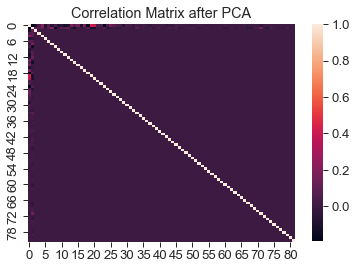

,occ_total_sum,oldest_phylostratum,cds_length,dnase_gene,dnase_cds,H3k4me1_gene,H3k4me3_gene,H3k27ac_gene,H3k4me1_cds,H3k4me3_cds,H3k27ac_cds,lamin_gene,repli_gene,nsome_gene,nsome_cds,transcription_gene,repeat_gene,repeat_cds,recomb_gene,AAA_freq,AAC_freq,AAG_freq,AAT_freq,ACA_freq,ACC_freq,ACG_freq,ACT_freq,AGA_freq,AGC_freq,AGG_freq,AGT_freq,ATA_freq,ATC_freq,ATG_freq,ATT_freq,CAA_freq,CAC_freq,CAG_freq,CAT_freq,CCA_freq,CCC_freq,CCG_freq,CCT_freq,CGA_freq,CGC_freq,CGG_freq,CGT_freq,CTA_freq,CTC_freq,CTG_freq,CTT_freq,GAA_freq,GAC_freq,GAG_freq,GAT_freq,GCA_freq,GCC_freq,GCG_freq,GCT_freq,GGA_freq,GGC_freq,GGG_freq,GGT_freq,GTA_freq,GTC_freq,GTG_freq,GTT_freq,TAA_freq,TAC_freq,TAG_freq,TAT_freq,TCA_freq,TCC_freq,TCG_freq,TCT_freq,TGA_freq,TGC_freq,TGG_freq,TGT_freq,TTA_freq,TTC_freq,TTG_freq
1,33,12.0,1488,0.612230,0.758065,0.561429,1.000000,0.216855,0.661290,1.000000,0.198925,0.0,0.041809,0.809254,0.706453,6.798234,0.040516,0.0,0.000000,0.004755,0.008152,0.007473,0.002717,0.011549,0.026495,0.010870,0.008152,0.010190,0.028533,0.019701,0.009511,0.000679,0.006114,0.010870,0.002038,0.009511,0.019022,0.028533,0.007473,0.027174,0.031250,0.025136,0.029891,0.015625,0.027174,0.019701,0.009511,0.007473,0.017663,0.044837,0.013587,0.008832,0.021739,0.031250,0.008152,0.016984,0.033967,0.027853,0.034647,0.023777,0.030571,0.029212,0.013587,0.000679,0.012908,0.027174,0.003397,0.000000,0.008152,0.000000,0.001359,0.008832,0.021739,0.009511,0.010190,0.020380,0.027174,0.029212,0.010870,0.000679,0.013587,0.005435
10,28,1.0,873,0.086769,0.195876,0.657839,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,-0.007148,0.828752,1.097018,0.061963,0.002809,0.0,2.043350,0.025258,0.019518,0.021814,0.024110,0.025258,0.018370,0.003444,0.012629,0.035591,0.009185,0.016073,0.006889,0.016073,0.017222,0.010333,0.033295,0.019518,0.011481,0.020666,0.022962,0.017222,0.008037,0.002296,0.021814,0.003444,0.001148,0.004592,0.002296,0.008037,0.019518,0.022962,0.019518,0.033295,0.013777,0.019518,0.011481,0.014925,0.006889,0.000000,0.012629,0.018370,0.011481,0.017222,0.018370,0.005741,0.008037,0.012629,0.012629,0.012629,0.014925,0.006889,0.017222,0.017222,0.016073,0.005741,0.022962,0.020666,0.012629,0.027555,0.011481,0.021814,0.017222,0.026406
100,36,1.0,1092,0.479295,0.611722,0.851369,0.354628,0.618954,0.754579,0.030220,0.086996,0.0,0.040463,1.249600,1.354306,6.081620,0.028404,0.0,0.868383,0.018727,0.012172,0.023408,0.003745,0.017790,0.024345,0.007491,0.014981,0.024345,0.020599,0.025281,0.011236,0.003745,0.013109,0.019663,0.004682,0.017790,0.016854,0.029963,0.017790,0.034644,0.022472,0.010300,0.028090,0.005618,0.010300,0.014045,0.003745,0.015918,0.015918,0.033708,0.011236,0.014981,0.022472,0.026217,0.009363,0.015918,0.031835,0.007491,0.025281,0.028090,0.029026,0.021536,0.013109,0.008427,0.010300,0.016854,0.003745,0.006554,0.012172,0.005618,0.008427,0.014981,0.016854,0.009363,0.008427,0.014981,0.019663,0.029026,0.010300,0.004682,0.010300,0.004682
1000,126,1.0,2800,0.171524,0.280357,0.554023,0.052420,0.278492,0.270357,0.021429,0.151429,0.0,-0.022495,0.921420,1.382249,2.254471,0.014520,0.0,1.143060,0.022054,0.014823,0.022415,0.024946,0.022054,0.014100,0.006146,0.015546,0.024946,0.016992,0.012292,0.015907,0.013377,0.021330,0.026392,0.017715,0.026392,0.011931,0.027477,0.017354,0.023861,0.016992,0.006508,0.019161,0.005785,0.003977,0.007954,0.003977,0.006146,0.010846,0.025307,0.015907,0.022415,0.022777,0.016269,0.018800,0.015184,0.016992,0.004700,0.014461,0.017354,0.010484,0.010123,0.011931,0.009400,0.007231,0.020607,0.011931,0.013738,0.008315,0.006146,0.016631,0.022054,0.018077,0.004700,0.009038,0.031092,0.019523,0.019523,0.016992,0.016269,0.014100,0.015907
10000,55,1.0,1484,0.143843,0.030997,0.400789,0.106455,0.457949,0.708221,0.030997,0.659704,0.0,-0.000387,0.960747,1.196871,1.080241,0.009545,0.0,4.217000,0.039835,0.015797,0.030220,0.025412,0.024038,0.012363,0.002747,0.019918,0.048077,0.006868,0.015797,0.009615,0.020604,0.009615,0.032280,0.023352,0.019918,0.012363,0.021978,0

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

class ConfounderPCA(BaseEstimator, TransformerMixin):
    """ 
    Custom PCA transformer for this dataset.
    Applies PCA only to the many collinear confounder 
    variables.
    
    cols - columns to which PCA will be applied.
    
    n_components - same as with the "vanilla" PCA. 
        If 0 < n_components < 1, select the number of 
        components such that the amount of variance that 
        needs to be explained is greater than the 
        percentage specified by n_components.
        
    apply_PCA - if false, simply returns the untransformed data.
    """

    def __init__(self, cols, n_components=None, apply_PCA=True):
        self.n_components = n_components
        self.apply_PCA = apply_PCA
        self.cols = cols
        if self.apply_PCA:
            self.pca = PCA(n_components=self.n_components)

    def fit(self, X, y=None):
        if self.apply_PCA:
            self.pca.fit(X[:, self.cols])
        return self

    def transform(self, X, y=None):
        if self.apply_PCA:
            X_pca = self.pca.transform(X[:, self.cols])
            return np.c_[X[:, :2], X_pca]
        else:
            return X

sns.heatmap(
    pd.DataFrame(
        ConfounderPCA(cols=np.arange(2, X.shape[1])).fit_transform(StandardScaler().fit_transform(X))
    ).corr()
)
plt.title("Correlation Matrix after PCA")
plt.show()

features_df

## Train-Test Split

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (14536, 82) (14536,)
Testing set shape: (3634, 82) (3634,)


## Custom Metric

In [7]:
from sklearn.metrics import auc, make_scorer, precision_recall_curve

def auprc(y_true, y_scores, **kwargs):
    """ Remember to use make_scorer(auprc, needs_proba=True,) """
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
    # results is area under x=Recall and y=Precision curve. 
    return auc(recalls, precisions)

***
# Feature importance by Permutation

The estimator is required to be a fitted estimator. X can be the data set used to train the estimator or a hold-out set. The permutation importance of a feature is calculated as follows:
- First, a baseline metric, defined by scoring, is evaluated on a **(potentially different)** dataset defined by the X. 
- Next, a feature column from the validation set is permuted and the metric is evaluated again. 
- The permutation importance is defined to be the difference between the baseline metric and metric from permutating the feature column.

In [8]:
from sklearn.inspection import permutation_importance

def calc_importances(model, x, y, ranseed=0):
    
    # Train/test split
    x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.2, random_state=ranseed)

    # Train the model on the dataset
    model.fit(x_tr, y_tr) 
    
    # Compare the model against other models trained on permutations of the dataset
    results = permutation_importance(model, x_te, y_te, n_repeats=10, random_state=ranseed, scoring=make_scorer(auprc, needs_proba=True,), n_jobs=-1)
    
    return pd.DataFrame(results.importances_mean, columns=["Score"], index=features_df.columns)

### PCA, Dropping Components to 95% Explained Variance

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Define the model
lr_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", ConfounderPCA(cols=np.arange(2, X.shape[1]), n_components=0.95)),
    ("lr", LogisticRegression(max_iter=2000, penalty='none')),
])

# Calculate importance scores using a train-test split
imp_pca_df = calc_importances(lr_clf, X, y, ranseed=42) 

# Fit and score the model
lr_clf.fit(X_train, y_train)
y_pred_proba = lr_clf.predict_proba(X_test)[:, 1]
print("Model rocauc score:", roc_auc_score(y_test, y_pred_proba))

Model rocauc score: 0.65464658687282


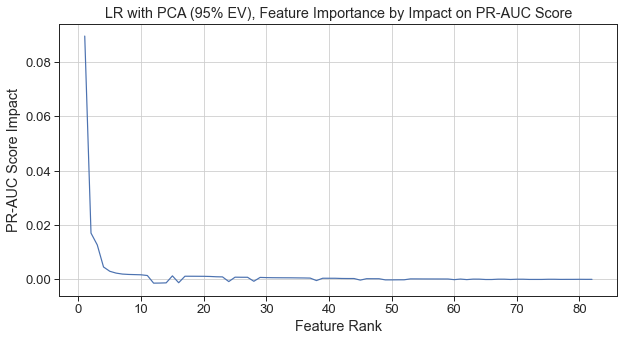

,Score
occ_total_sum,0.089598
oldest_phylostratum,0.017028
cds_length,0.012679
repeat_cds,0.004551
TGG_freq,0.002966
TCT_freq,0.002300
CAA_freq,0.001941
ATG_freq,0.001802
ACT_freq,0.001737
GAT_freq,0.001671


In [10]:
data = imp_pca_df.sort_values(by="Score", key=abs, ascending=False)

# Plot
plt.figure(figsize=(10,5))
sns.lineplot(x=np.arange(1, X.shape[1]+1), y=data.to_numpy().flatten())
plt.title("LR with PCA (95% EV), Feature Importance by Impact on PR-AUC Score")
plt.ylabel("PR-AUC Score Impact")
plt.xlabel("Feature Rank")
plt.show()

# Print the feature matrix sorted by importance
data.head(10)

### Without PCA

In [11]:
# Define the model
lr_clf = Pipeline([
    ("scaler", StandardScaler()),
    # ("pca", ConfounderPCA()),
    ("lr", LogisticRegression(max_iter=2000, penalty='none')),
])

# Score its features
imp_npca_df = calc_importances(lr_clf, X, y, ranseed=12) 

# Fit and score the model
lr_clf.fit(X_train, y_train)
y_pred_proba = lr_clf.predict_proba(X_test)[:, 1]
print("Model rocauc score:", roc_auc_score(y_test, y_pred_proba))

Model rocauc score: 0.6578385107528734


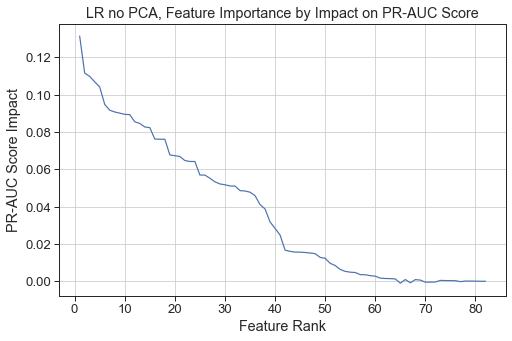

,Score
TAT_freq,0.131499
GTG_freq,0.111605
TGT_freq,0.109866
ATA_freq,0.106951
TGC_freq,0.104203
CGG_freq,0.094832
TAC_freq,0.091723
TTG_freq,0.090778
CCA_freq,0.090154
occ_total_sum,0.089500


In [12]:
data = imp_npca_df.sort_values(by="Score", key=abs, ascending=False)

# Plot
plt.figure(figsize=(8,5))
sns.lineplot(x=np.arange(1, X.shape[1]+1), y=data.to_numpy().flatten())
plt.title("LR no PCA, Feature Importance by Impact on PR-AUC Score")
plt.ylabel("PR-AUC Score Impact")
plt.xlabel("Feature Rank")
plt.show()

# Print the feature matrix sorted by importance
data.head(10)

### Without dropping components

In [13]:
lr_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", ConfounderPCA(cols=np.arange(2, X.shape[1]), n_components=None)),
    ("lr", LogisticRegression(max_iter=2000, penalty='none')),
])

imp_pca_all_df = calc_importances(lr_clf, X_train, y_train, ranseed=12) 

# Fit and score the model
lr_clf.fit(X_train, y_train)
y_pred_proba = lr_clf.predict_proba(X_test)[:, 1]
print("Model rocauc score:", roc_auc_score(y_test, y_pred_proba))

Model rocauc score: 0.6578130093636851


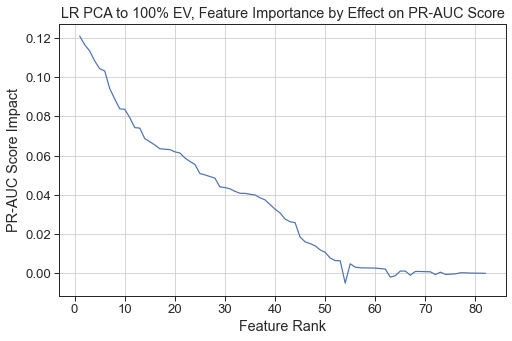

,Score
ATA_freq,0.120973
TGT_freq,0.116569
TTA_freq,0.113371
GTG_freq,0.108256
CCA_freq,0.104303
TAT_freq,0.103173
AGT_freq,0.094187
CTG_freq,0.088873
GTC_freq,0.083866
TAC_freq,0.083601


In [14]:
data = imp_pca_all_df.sort_values(by="Score", key=abs, ascending=False)

# Plot
plt.figure(figsize=(8,5))
sns.lineplot(x=np.arange(1, X.shape[1]+1), y=data.to_numpy().flatten())
plt.title("LR PCA to 100% EV, Feature Importance by Effect on PR-AUC Score")
plt.ylabel("PR-AUC Score Impact")
plt.xlabel("Feature Rank")
plt.show()

# Print the feature matrix sorted by importance
data.head(10)

***
# Permutation of PCs

In [22]:
# Pre-process the data
scaler = StandardScaler()
pca = ConfounderPCA(cols=np.arange(2, X.shape[1]), n_components=None)
X_pca = pca.fit_transform(scaler.fit_transform(X))

# Train-test split
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Define the model
lr_clf = LogisticRegression(max_iter=2000, penalty='none')

# Calculate importance scores using a train-test split

# Train/test split
x_tr, x_te, y_tr, y_te = train_test_split(X_pca, y, test_size=0.2, random_state=7)

# Train the model on the dataset
lr_clf.fit(x_tr, y_tr) 

# Compare the model against other models trained on permutations of the dataset
results = permutation_importance(lr_clf, x_te, y_te, n_repeats=10, random_state=5, scoring=make_scorer(auprc, needs_proba=True,), n_jobs=-1)

imp_prepca_df = pd.DataFrame(results.importances_mean, columns=["Score"], )
imp_prepca_df.rename(index={0 : "occ_total_sum", 1 : "oldest_phylostratum"}, inplace=True)
imp_prepca_df.rename(index=lambda s: f"PC {s-1}" if isinstance(s, int) else s, inplace=True)

imp_prepca_df.to_csv("./data/lr/lr_pc_importances_prauc.csv")

In [23]:
# Fit and score the model
lr_clf.fit(X_train_pca, y_train)
y_pred_proba = lr_clf.predict_proba(X_test_pca)[:, 1]
print("Model rocauc score:", roc_auc_score(y_test, y_pred_proba))

Model rocauc score: 0.6578474362390891


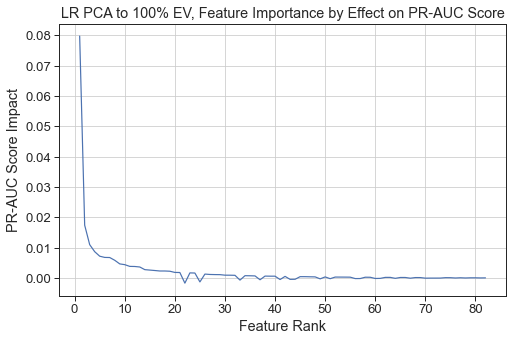

,Score
occ_total_sum,0.079782
oldest_phylostratum,0.017382
PC 9,0.010962
PC 70,0.008640
PC 6,0.007151
PC 3,0.006750
PC 4,0.006712
PC 13,0.005805
PC 12,0.004610
PC 40,0.004361


In [24]:
data = imp_prepca_df.sort_values(by="Score", key=abs, ascending=False)

# Plot
plt.figure(figsize=(8,5))
sns.lineplot(x=np.arange(1, X.shape[1]+1), y=data.to_numpy().flatten())
plt.title("LR PCA to 100% EV, Feature Importance by Effect on PR-AUC Score")
plt.ylabel("PR-AUC Score Impact")
plt.xlabel("Feature Rank")
plt.show()

# Print the feature matrix sorted by importance
data.head(10)

***
# Summary of Results

In [18]:
results_df = pd.DataFrame()

results_df["Top Variables PCA 95%"] = imp_pca_df.sort_values(by="Score", key=abs, ascending=False).index
results_df["Scores PCA 95%"] = imp_pca_df.sort_values(by="Score", key=abs, ascending=False).Score.to_numpy()

results_df["Top Variables PCA 100%"] = imp_pca_all_df.sort_values(by="Score", key=abs, ascending=False).index
results_df["Scores PCA 100%"] = imp_pca_all_df.sort_values(by="Score", key=abs, ascending=False).Score.to_numpy()

results_df["Top Variables No PCA"] = imp_npca_df.sort_values(by="Score", key=abs, ascending=False).index
results_df["Scores No PCA"] = imp_npca_df.sort_values(by="Score", key=abs, ascending=False).Score.to_numpy()

results_df.head(5)

,Top Variables PCA 95%,Scores PCA 95%,Top Variables PCA 100%,Scores PCA 100%,Top Variables No PCA,Scores No PCA
0,occ_total_sum,0.089598,ATA_freq,0.120973,TAT_freq,0.131499
1,oldest_phylostratum,0.017028,TGT_freq,0.116569,GTG_freq,0.111605
2,cds_length,0.012679,TTA_freq,0.113371,TGT_freq,0.109866
3,repeat_cds,0.004551,GTG_freq,0.108256,ATA_freq,0.106951
4,TGG_freq,0.002966,CCA_freq,0.104303,TGC_freq,0.104203


In [19]:
imp_prepca_df.head(5)

,Score
occ_total_sum,0.046107
oldest_phylostratum,0.020153
PC 1,0.004023
PC 2,-0.000269
PC 3,0.009911


In [20]:
output_df = pd.DataFrame()
output_df["LR PCA 95% EV"] = imp_pca_df["Score"]
output_df["LR PCA 100% EV"] = imp_pca_all_df["Score"]
output_df["LR NO PCA"] = imp_npca_df["Score"]
output_df.to_csv("./data/lr/lr_scores_prauc.csv")
output_df.head(5)

,LR PCA 95% EV,LR PCA 100% EV,LR NO PCA
occ_total_sum,0.089598,0.079362,0.089500
oldest_phylostratum,0.017028,0.018461,0.016649
cds_length,0.012679,0.016039,0.015578
dnase_gene,-0.000454,0.007789,-0.000231
dnase_cds,0.000706,0.000046,-0.000862


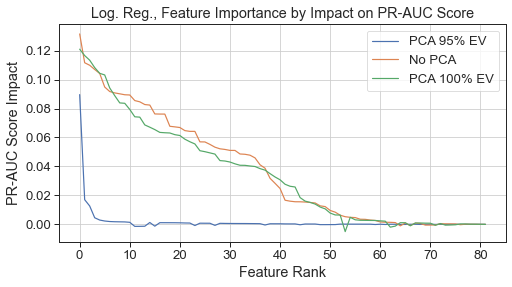

In [21]:
plt.figure(figsize=(8,4))

sns.lineplot(x=np.arange(X.shape[1]), y=results_df["Scores PCA 95%"].to_numpy().flatten(), label="PCA 95% EV")
sns.lineplot(x=np.arange(X.shape[1]), y=results_df["Scores No PCA"].to_numpy().flatten(), label="No PCA") 
sns.lineplot(x=np.arange(X.shape[1]), y=results_df["Scores PCA 100%"].to_numpy().flatten(), label="PCA 100% EV") 
plt.title("Log. Reg., Feature Importance by Impact on PR-AUC Score")
plt.ylabel("PR-AUC Score Impact")
plt.xlabel("Feature Rank")
plt.grid(True)
plt.savefig("./figures/lr_feature_importance_curve.png")
plt.show()